In [261]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.evaluate import permutation_test

from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler

from PAINTeR import plot # in-house lib used for the RPN-signature

import joblib

In [262]:
df = pd.read_csv('~/datasets/ds000208/participants.tsv', sep='\t')
df['sub'] = df['participant_id'].str.split('sub-', 3, expand=True)[1].astype(int)
df

,participant_id,type,study,gender,Age,Drug,Response,% Analsesia VAS,% Analgesia WOMAC,sub
0,sub-01,control,NaN,female,59,NaN,NaN,NaN,NaN,1
1,sub-02,control,NaN,male,59,NaN,NaN,NaN,NaN,2
2,sub-03,control,NaN,male,52,NaN,NaN,NaN,NaN,3
3,sub-04,control,NaN,male,48,NaN,NaN,NaN,NaN,4
4,sub-05,control,NaN,male,78,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...
71,sub-72,patient,2.0,male,49,placebo,0.0,10.04,19.35,72
72,sub-73,patient,2.0,male,73,placebo,0.0,-19.94,9.86,73
73,sub-74,patient,2.0,female,63,placebo,0.0,-4.95,-15.63,74
74,sub-75,patient,2.0,female,70,placebo,0.0,5.21,-21.57,75


In [263]:
rpn = pd.read_csv('~/datasets/ds000208/derivatives/rpn-signature_v0.2.6/RPNresults.csv')
rpn['sub'] = rpn['in_file'].str.split('[-_]', 3, expand=True)[2].astype(int)
rpn

,Unnamed: 0,in_file,RPN,sub
0,0,/data/sub-01/func/sub-01_task-rest_bold.nii.gz,0.091564,1
1,1,/data/sub-02/func/sub-02_task-rest_bold.nii.gz,-0.262176,2
2,2,/data/sub-03/func/sub-03_task-rest_bold.nii.gz,0.298997,3
3,3,/data/sub-04/func/sub-04_task-rest_bold.nii.gz,-0.308391,4
4,4,/data/sub-05/func/sub-05_task-rest_bold.nii.gz,0.658912,5
...,...,...,...,...
71,71,/data/sub-72/func/sub-72_task-rest_bold.nii.gz,0.305689,72
72,72,/data/sub-73/func/sub-73_task-rest_bold.nii.gz,-0.101891,73
73,73,/data/sub-74/func/sub-74_task-rest_bold.nii.gz,-0.086307,74
74,74,/data/sub-75/func/sub-75_task-rest_bold.nii.gz,-0.049659,75


In [264]:
motion = pd.read_csv('~/datasets/ds000208/derivatives/rpn-signature_v0.2.6/motion_summary.csv')
motion['Unnamed: 0'] = motion['Unnamed: 0'].astype(int)
sub_ids = pd.read_csv('~/datasets/ds000208/derivatives/rpn-signature_v0.2.6/subjectsIDs.txt', header=None, sep='\t')
sub_ids[0] = sub_ids[0].astype(int)
sub_ids['nipype_idx'] = sub_ids[0]
sub_ids['sub'] = sub_ids[1].str.split('[-_]', 3, expand=True)[2].astype(int)
motion = motion.merge(sub_ids[[0, 'sub', 'nipype_idx']], left_on='Unnamed: 0', right_on=0)[['sub', 'nipype_idx', 'meanFD', 'medianFD', 'maxFD', 'perc_scrubbed']]
motion

,sub,nipype_idx,meanFD,medianFD,maxFD,perc_scrubbed
0,1,0,0.287986,0.268500,1.235619,90
1,2,1,0.094148,0.083585,0.788178,7
2,3,2,0.229082,0.214409,0.668397,82
3,4,3,0.092291,0.069992,0.528105,15
4,5,4,0.095123,0.081575,0.696880,12
...,...,...,...,...,...,...
71,72,71,0.738567,0.531382,5.141640,93
72,73,72,0.251921,0.233625,0.978815,84
73,74,73,0.250625,0.234233,0.740522,82
74,75,74,0.199762,0.185565,0.865275,64


In [265]:
df = df.merge(rpn[['RPN', 'sub']], on='sub').merge(motion, on='sub')
df

,participant_id,type,study,gender,Age,Drug,Response,% Analsesia VAS,% Analgesia WOMAC,sub,RPN,nipype_idx,meanFD,medianFD,maxFD,perc_scrubbed
0,sub-01,control,NaN,female,59,NaN,NaN,NaN,NaN,1,0.091564,0,0.287986,0.268500,1.235619,90
1,sub-02,control,NaN,male,59,NaN,NaN,NaN,NaN,2,-0.262176,1,0.094148,0.083585,0.788178,7
2,sub-03,control,NaN,male,52,NaN,NaN,NaN,NaN,3,0.298997,2,0.229082,0.214409,0.668397,82
3,sub-04,control,NaN,male,48,NaN,NaN,NaN,NaN,4,-0.308391,3,0.092291,0.069992,0.528105,15
4,sub-05,control,NaN,male,78,NaN,NaN,NaN,NaN,5,0.658912,4,0.095123,0.081575,0.696880,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,sub-72,patient,2.0,male,49,placebo,0.0,10.04,19.35,72,0.305689,71,0.738567,0.531382,5.141640,93
72,sub-73,patient,2.0,male,73,placebo,0.0,-19.94,9.86,73,-0.101891,72,0.251921,0.233625,0.978815,84
73,sub-74,patient,2.0,female,63,placebo,0.0,-4.95,-15.63,74,-0.086307,73,0.250625,0.234233,0.740522,82
74,sub-75,patient,2.0,female,70,placebo,0.0,5.21,-21.57,75,-0.049659,74,0.199762,0.185565,0.865275,64


0.8933333333333333
(32, 123)
0.06999999999999995
(279, 123)
0.8166666666666667
(55, 123)
0.1466666666666666
(256, 123)
0.11333333333333329
(266, 123)
0.2466666666666667
(226, 123)
0.06333333333333335
(281, 123)
0.036666666666666625
(289, 123)
0.1266666666666667
(262, 123)
0.15666666666666662
(253, 123)
0.32333333333333336
(203, 123)
0.7566666666666666
(73, 123)
0.2733333333333333
(218, 123)
0.23333333333333328
(230, 123)
0.7
(90, 123)
0.043333333333333335
(287, 123)
0.1466666666666666
(256, 123)
0.17000000000000004
(249, 123)
0.5133333333333333
(146, 123)
0.08666666666666667
(274, 123)
0.33999999999999997
(198, 123)
0.15333333333333332
(254, 123)
0.036666666666666625
(289, 123)
0.5666666666666667
(130, 123)
0.9299999999999999
(21, 123)
0.8533333333333333
(44, 123)
0.88
(36, 123)
0.7233333333333334
(83, 123)
0.5466666666666666
(136, 123)
0.7166666666666667
(85, 123)
0.046666666666666634
(286, 123)
0.94
(18, 123)
0.91
(27, 123)
0.20333333333333337
(239, 123)
0.92
(24, 123)
0.013333333333

/tmp/ipykernel_1018660/1438514281.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.study[df.study.isna()] = 0.0


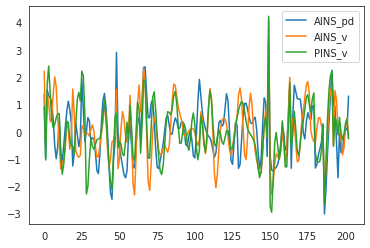

In [386]:
#scrub threshold

scrub_threshold = 0.15
mean_fd_threshold = 0.15
perc_scrubbed_threshold = 0.3

timeseries = []
perc_scrubbed = []
missing = []

for ni in df['nipype_idx']:
    f = '~/datasets/ds000208/derivatives/rpn-signature_v0.2.6/regional_timeseries/_extract_timeseries' + str(ni) + '.tsv'
    ts = pd.read_csv(f, sep='\t')
    regions = ts.columns.values
    ts = ts.values

    # scrub:
    fd = pd.read_csv('~/datasets/ds000208/derivatives/rpn-signature_v0.2.6/func_preproc/mc_fd/_calculate_FD_Power' + str(ni) + '.txt').values.flatten()
    fd = np.hstack((0, fd)) # 0 for the first frame

    perc_scrubbed.append( 1 - len(ts[fd<scrub_threshold])/len(ts))
    print(perc_scrubbed[-1])

    ts = ts[fd<=scrub_threshold]

    ts = StandardScaler().fit_transform(ts)

    timeseries.append(ts)
    print(ts.shape)
    missing.append((ts.std(axis=0) == 0).sum())

# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=regions).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

df['perc_scrubbed'] = perc_scrubbed
df['missing'] = missing
df.study[df.study.isna()] = 0.0

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

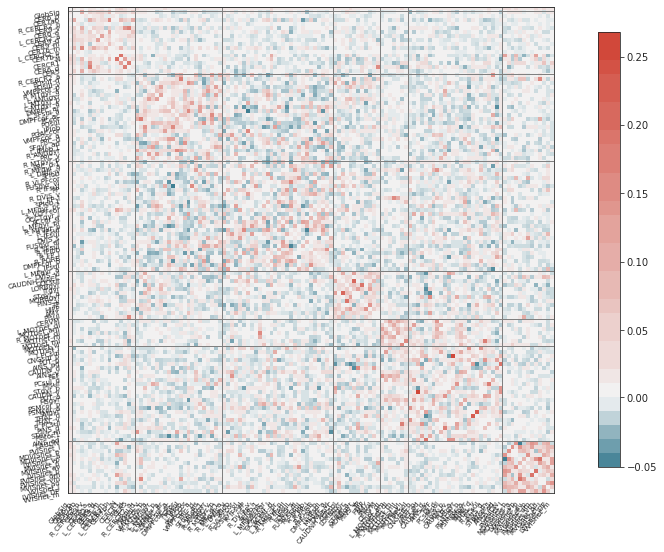

In [387]:
labels=regions
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
plot.plot_matrix(mat, labels, modules)

In [388]:
model = joblib.load('../res/multi-center/finalized_model_multi-center.joblib')

df['mc_rpn'] = model.predict(X)
df

,participant_id,type,study,gender,Age,Drug,Response,% Analsesia VAS,% Analgesia WOMAC,sub,RPN,nipype_idx,meanFD,medianFD,maxFD,perc_scrubbed,mc_rpn,missing
0,sub-01,control,0.0,female,59,NaN,NaN,NaN,NaN,1,0.091564,0,0.287986,0.268500,1.235619,0.893333,-0.382937,2
1,sub-02,control,0.0,male,59,NaN,NaN,NaN,NaN,2,-0.262176,1,0.094148,0.083585,0.788178,0.070000,-0.095420,4
2,sub-03,control,0.0,male,52,NaN,NaN,NaN,NaN,3,0.298997,2,0.229082,0.214409,0.668397,0.816667,-0.094773,7
3,sub-04,control,0.0,male,48,NaN,NaN,NaN,NaN,4,-0.308391,3,0.092291,0.069992,0.528105,0.146667,-0.003893,4
4,sub-05,control,0.0,male,78,NaN,NaN,NaN,NaN,5,0.658912,4,0.095123,0.081575,0.696880,0.113333,0.132640,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,sub-72,patient,2.0,male,49,placebo,0.0,10.04,19.35,72,0.305689,71,0.738567,0.531382,5.141640,0.923333,-0.153503,2
72,sub-73,patient,2.0,male,73,placebo,0.0,-19.94,9.86,73,-0.101891,72,0.251921,0.233625,0.978815,0.833333,0.059408,1
73,sub-74,patient,2.0,female,63,placebo,0.0,-4.95,-15.63,74,-0.086307,73,0.250625,0.234233,0.740522,0.820000,0.122160,0
74,sub-75,patient,2.0,female,70,placebo,0.0,5.21,-21.57,75,-0.049659,74,0.199762,0.185565,0.865275,0.633333,-0.066555,0


0.04195804195804196

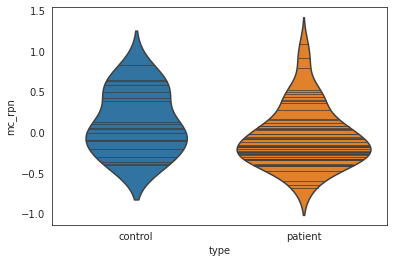

In [389]:
sns.violinplot(data=df, x='type', y='mc_rpn', inner='stick')

p_value = permutation_test(
    df.loc[df.type == 'control', 'mc_rpn'], df.loc[df.type == 'patient', 'mc_rpn'], method="approximate", seed=4242, num_rounds=1000, func='x_mean > y_mean'
)
p_value

(0.035096490350964904, 0.0877912208779122)

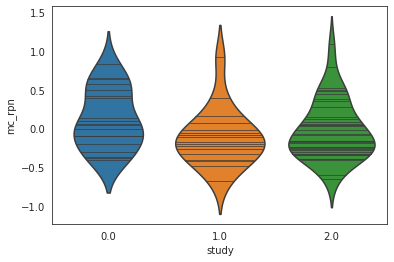

In [390]:
sns.violinplot(data=df, x='study', y='mc_rpn', inner='stick')

p_value01 = permutation_test(
    df.loc[df.study == 0, 'mc_rpn'], df.loc[df.study == 1, 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value02 = permutation_test(
    df.loc[df.study == 0, 'mc_rpn'], df.loc[df.study == 2, 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value01, p_value02

0.2420757924207579

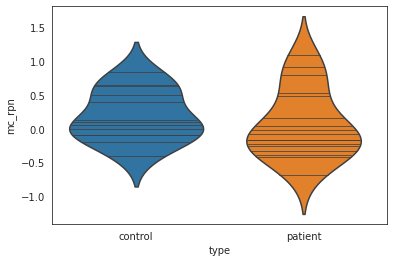

In [391]:
df_excl = df[(df.meanFD < mean_fd_threshold) & (df.perc_scrubbed < perc_scrubbed_threshold)]

sns.violinplot(data=df_excl, x='type', y='mc_rpn', inner='stick')
p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', 'mc_rpn'], df_excl.loc[df_excl.type == 'patient', 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value
#np.mean(df_excl.loc[df_excl.type == 'control', 'mc_rpn']), np.mean(df_excl.loc[df_excl.type == 'patient', 'mc_rpn'])


0.25007499250074994

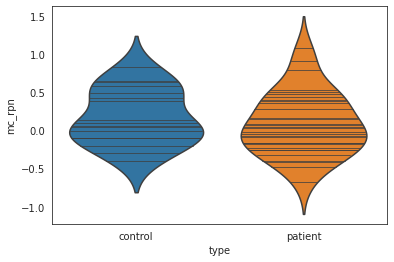

In [392]:
df_excl = df[(df.meanFD < 0.25) & (df.perc_scrubbed < 1)]

sns.violinplot(data=df_excl, x='type', y='mc_rpn', inner='stick')
p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', 'mc_rpn'], df_excl.loc[df_excl.type == 'patient', 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value
#np.mean(df_excl.loc[df_excl.type == 'control', 'mc_rpn']), np.mean(df_excl.loc[df_excl.type == 'patient', 'mc_rpn'])


0.0093990600939906

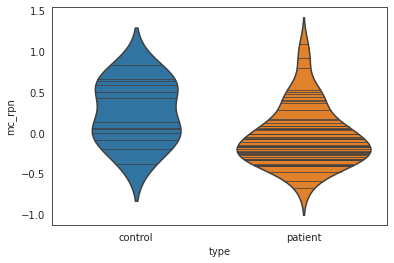

In [393]:
df_excl = df[df.missing < 6]

sns.violinplot(data=df_excl, x='type', y='mc_rpn', inner='stick')
p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', 'mc_rpn'], df_excl.loc[df_excl.type == 'patient', 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value
#np.mean(df_excl.loc[df_excl.type == 'control', 'mc_rpn']), np.mean(df_excl.loc[df_excl.type == 'patient', 'mc_rpn'])

0.0093990600939906

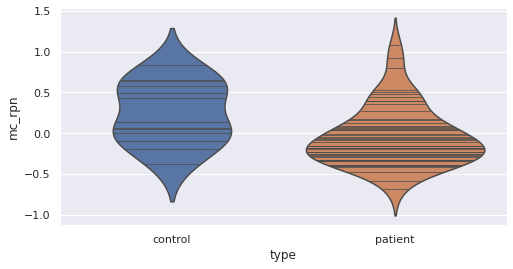

In [543]:
df_excl = df[df.missing < 6]

sns.violinplot(data=df_excl, x='type', y='mc_rpn', inner='stick')
p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', 'mc_rpn'], df_excl.loc[df_excl.type == 'patient', 'mc_rpn'], method="approximate", seed=42, num_rounds=10000, func='x_mean > y_mean'
)
p_value
#np.mean(df_excl.loc[df_excl.type == 'control', 'mc_rpn']), np.mean(df_excl.loc[df_excl.type == 'patient', 'mc_rpn'])

In [433]:
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features

mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    #conns_mc_model(i_a, i_b)
    conns_mc_model[:, idx] = X[:, i_a, i_b]
    #if mc_model.loc[idx, 'multi-center'] < 0:
    #    conns_mc_model[:, idx] *= -1
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.016343,-0.002581,-0.023277,-0.000000,0.083173,-0.037582,0.002748,-0.012033,-0.028718,-0.005972,...,-0.006382,-0.019656,-0.023676,0.084511,0.006604,0.025925,0.037037,0.012385,0.009053,0.035463
1,0.021294,-0.096780,0.017273,-0.000000,0.125559,0.042251,-0.039472,0.142016,-0.043828,0.084657,...,-0.064944,0.106732,-0.016876,0.012547,0.041672,-0.010693,0.022180,0.059078,-0.033251,-0.048773
2,0.021629,-0.063179,-0.015022,-0.000000,0.056027,0.012844,0.042499,-0.001827,-0.000000,-0.000000,...,-0.029390,-0.028836,0.044904,-0.001744,-0.047878,0.011209,0.035780,0.035257,0.026731,0.070278
3,0.030203,0.080807,0.047805,0.000000,0.196107,0.052941,-0.054856,-0.031811,-0.005818,0.047445,...,0.015931,0.076380,-0.033286,-0.068783,0.085744,0.096762,0.080638,0.013264,-0.008031,-0.032916
4,0.021722,0.051536,0.042399,0.000000,0.022920,0.033092,-0.028301,0.031521,-0.078277,0.008810,...,-0.112731,0.119192,0.050884,0.188033,0.054588,-0.066447,0.090581,0.003119,0.025525,0.143270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.009701,0.013431,0.015481,0.071568,0.068211,0.028554,-0.028963,-0.024925,0.016507,0.028602,...,-0.038512,0.003467,0.033232,0.108000,-0.010403,-0.007329,0.024138,-0.032776,0.024421,0.020136
72,0.002821,0.076935,0.037778,-0.072852,0.089231,-0.047572,0.023632,0.034122,0.051963,0.136028,...,-0.033466,-0.010587,0.020683,-0.011254,-0.031905,0.048946,0.027623,0.028678,0.029419,0.029574
73,0.016251,0.031454,-0.066778,-0.039378,0.168001,-0.048010,-0.018103,-0.039551,-0.046612,-0.017796,...,-0.008030,0.029332,-0.047433,-0.018515,-0.002765,0.026399,0.018548,-0.020419,0.135128,-0.074424
74,0.011025,0.042410,0.066856,0.111987,0.142703,-0.070004,0.030426,-0.085285,0.044485,-0.139687,...,0.046273,0.087263,0.034992,0.059276,0.065381,0.000532,0.018653,-0.061529,0.068460,0.047146


<AxesSubplot:xlabel='value', ylabel='connectivity'>

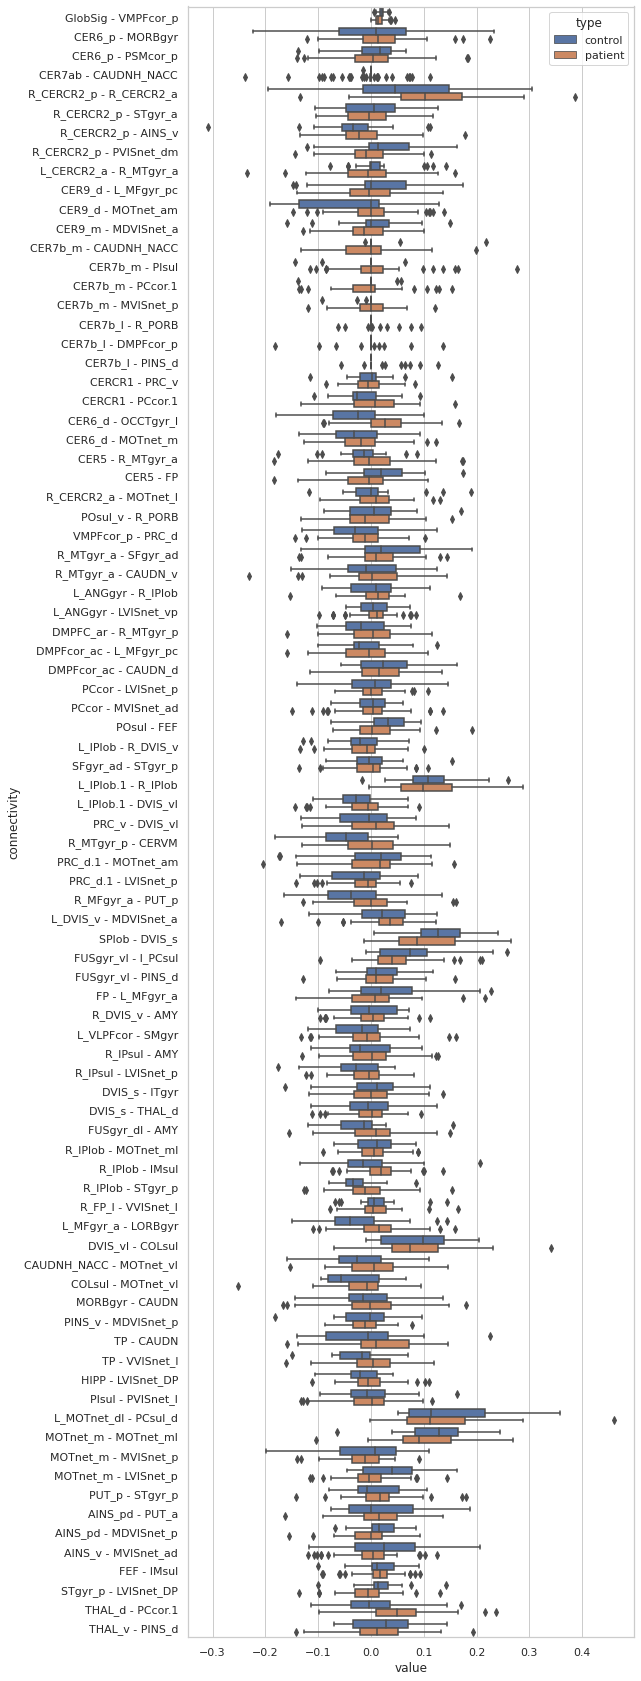

In [434]:
conns_mc_model['type'] = df['type']
sns.set(rc={"figure.figsize":(8, 30)})
sns.set_style("whitegrid")
sns.boxplot(data = conns_mc_model.melt('type'), y='connectivity', x='value', hue='type')

In [438]:
comps = pd.read_csv('../res/multi-center/component-labels.csv')

/tmp/ipykernel_1018660/2551580555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['type'] = conns_mc_model.type


<AxesSubplot:xlabel='type', ylabel='value'>

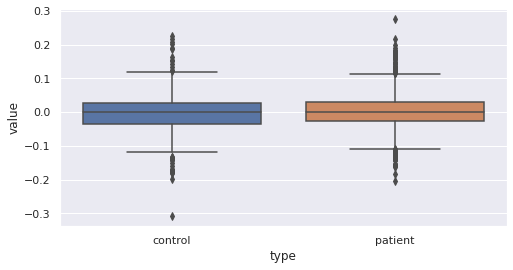

In [448]:
sns.set(rc={"figure.figsize":(8, 4)})
tmp_df = conns_mc_model[comps.loc[comps.label == 0, 'connectivity']]
tmp_df['type'] = conns_mc_model.type

sns.boxplot(data = tmp_df.melt('type'), y='value', x='type')

/tmp/ipykernel_1018660/935603716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['type'] = conns_mc_model.type


<AxesSubplot:xlabel='type', ylabel='value'>

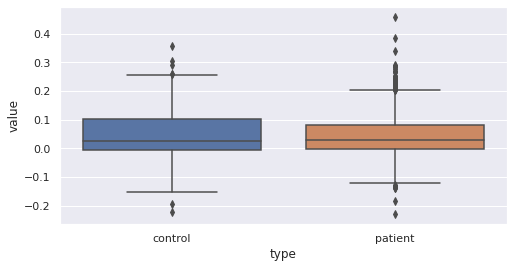

In [449]:
sns.set(rc={"figure.figsize":(8, 4)})
tmp_df = conns_mc_model[comps.loc[comps.label == 1, 'connectivity']]
tmp_df['type'] = conns_mc_model.type

sns.boxplot(data = tmp_df.melt('type'), y='value', x='type')

/tmp/ipykernel_1018660/2661163632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['type'] = conns_mc_model.type


<AxesSubplot:xlabel='type', ylabel='value'>

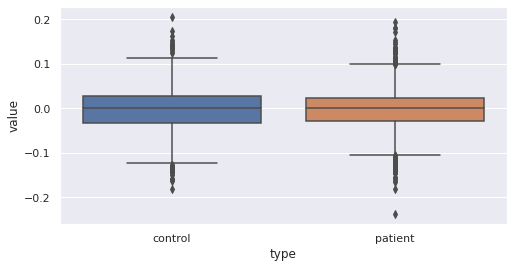

In [450]:
sns.set(rc={"figure.figsize":(8, 4)})
tmp_df = conns_mc_model[comps.loc[comps.label == 2, 'connectivity']]
tmp_df['type'] = conns_mc_model.type

sns.boxplot(data = tmp_df.melt('type'), y='value', x='type')

/tmp/ipykernel_1018660/1417115950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['type'] = conns_mc_model.type


<AxesSubplot:xlabel='type', ylabel='value'>

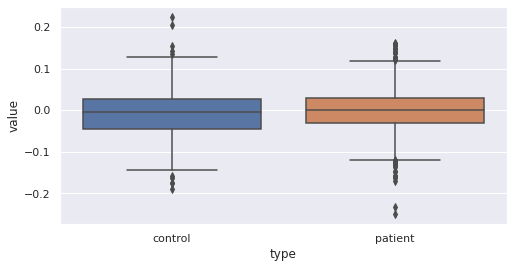

In [451]:
sns.set(rc={"figure.figsize":(8, 4)})
tmp_df = conns_mc_model[comps.loc[comps.label == 3, 'connectivity']]
tmp_df['type'] = conns_mc_model.type

sns.boxplot(data = tmp_df.melt('type'), y='value', x='type')

In [454]:
mc_model[['connectivity', 'multi-center']]

,connectivity,multi-center
0,GlobSig - VMPFcor_p,0.072555
1,CER6_p - MORBgyr,0.004827
2,CER6_p - PSMcor_p,-0.082088
3,CER7ab - CAUDNH_NACC,0.034224
4,R_CERCR2_p - R_CERCR2_a,0.022155
...,...,...
80,AINS_v - MVISnet_ad,-0.083777
81,FEF - IMsul,0.016332
82,STgyr_p - LVISnet_DP,0.032784
83,THAL_d - PCcor.1,0.030910


In [456]:
model = mc_model.merge(comps, on='connectivity')

In [477]:
sub_conn = conns_mc_model
sub_conn['sub'] = df['sub']
for l in model.label:
    scores = []
    for sub in sub_conn['sub']:
        score = 0
        #print(sub)
        for i in model[model.label == l].index:
            score += sub_conn.loc[sub_conn['sub'] == sub, model.loc[i, 'connectivity']].values[0] * model.loc[i, 'multi-center']
        #print(score)
        scores.append(score)
    df['component_' + str(l)] = scores
df


,participant_id,type,study,gender,Age,Drug,Response,% Analsesia VAS,% Analgesia WOMAC,sub,...,meanFD,medianFD,maxFD,perc_scrubbed,mc_rpn,missing,component_1,component_0,component_2,component_3
0,sub-01,control,0.0,female,59,NaN,NaN,NaN,NaN,1,...,0.287986,0.268500,1.235619,0.893333,-0.382937,2,-0.011350,0.001672,0.003532,0.001685
1,sub-02,control,0.0,male,59,NaN,NaN,NaN,NaN,2,...,0.094148,0.083585,0.788178,0.070000,-0.095420,4,0.000458,0.003732,-0.006040,0.004654
2,sub-03,control,0.0,male,52,NaN,NaN,NaN,NaN,3,...,0.229082,0.214409,0.668397,0.816667,-0.094773,7,0.007343,0.003852,0.001262,-0.002609
3,sub-04,control,0.0,male,48,NaN,NaN,NaN,NaN,4,...,0.092291,0.069992,0.528105,0.146667,-0.003893,4,0.024288,0.004167,-0.007371,-0.007282
4,sub-05,control,0.0,male,78,NaN,NaN,NaN,NaN,5,...,0.095123,0.081575,0.696880,0.113333,0.132640,4,-0.000314,-0.002097,0.013861,0.013338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,sub-72,patient,2.0,male,49,placebo,0.0,10.04,19.35,72,...,0.738567,0.531382,5.141640,0.923333,-0.153503,2,0.019830,-0.011281,0.009553,-0.005744
72,sub-73,patient,2.0,male,73,placebo,0.0,-19.94,9.86,73,...,0.251921,0.233625,0.978815,0.833333,0.059408,1,0.031157,-0.009195,-0.008281,0.012400
73,sub-74,patient,2.0,female,63,placebo,0.0,-4.95,-15.63,74,...,0.250625,0.234233,0.740522,0.820000,0.122160,0,0.025470,0.006690,-0.016035,0.013256
74,sub-75,patient,2.0,female,70,placebo,0.0,5.21,-21.57,75,...,0.199762,0.185565,0.865275,0.633333,-0.066555,0,0.010763,0.001358,0.001602,0.005699


0.03949605039496051

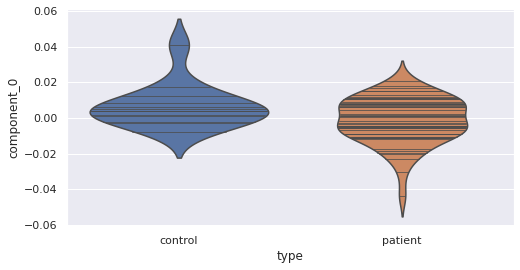

In [534]:
var = 'component_0' # pain neg

df_excl = df[df.missing<6]
sns.violinplot(data=df_excl, x='type', y=var, inner='stick')

p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', var], df_excl.loc[df_excl.type == 'patient', var], method="approximate", seed=42, num_rounds=10000
)
p_value

0.5864135864135864

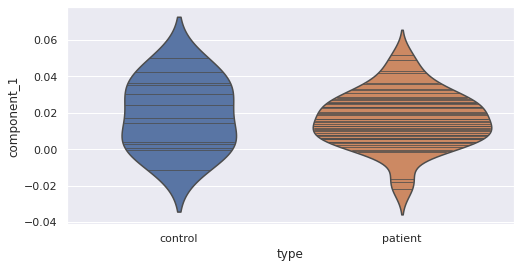

In [535]:
var = 'component_1' # pain pos, anx neg


df_excl = df[df.missing<6]
sns.violinplot(data=df_excl, x='type', y=var, inner='stick')

p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', var], df_excl.loc[df_excl.type == 'patient', var], method="approximate", seed=42, num_rounds=1000
)
p_value

0.8951048951048951

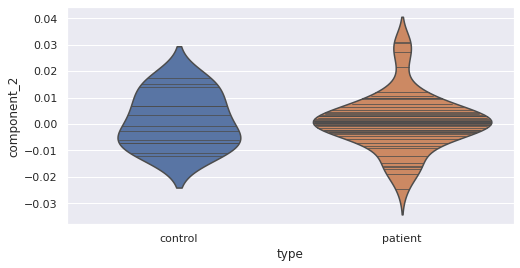

In [536]:
var = 'component_2' # pain pos anx neutral

df_excl = df[df.missing<6]
sns.violinplot(data=df_excl, x='type', y=var, inner='stick')

p_value = permutation_test(
    df_excl.loc[df_excl.type == 'control', var], df_excl.loc[df_excl.type == 'patient', var], method="approximate", seed=42, num_rounds=1000
)
p_value

0.007699230076992301

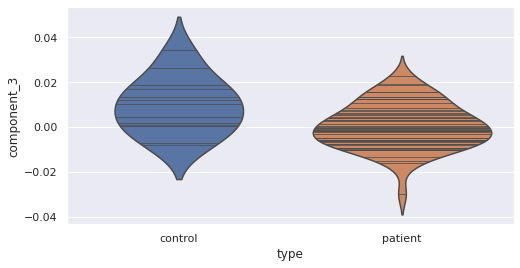

In [537]:
var = 'component_3' # pain neg, rumination negative

df_excl = df[df.missing<6]

sns.violinplot(data=df_excl, x='type', y=var, inner='stick')

p_value = permutation_test(
    df_excl.loc[df.type == 'control', var], df_excl.loc[df.type == 'patient', var], method="approximate", seed=42, num_rounds=10000
)
p_value

0.2161783821617838

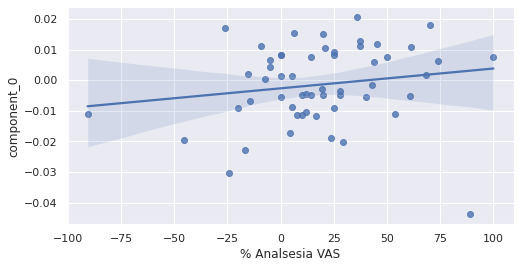

In [538]:
var = 'component_0'

df_excl = df[df.missing<6].dropna()

sns.regplot(data=df_excl, x='% Analsesia VAS', y=var)

p_value = permutation_test(
    df_excl['% Analsesia VAS'], df_excl[var], method="approximate", seed=42, num_rounds=10000, func=lambda x, y: np.abs(np.corrcoef(x, y)[1][0]),
)
p_value

0.042495750424957505

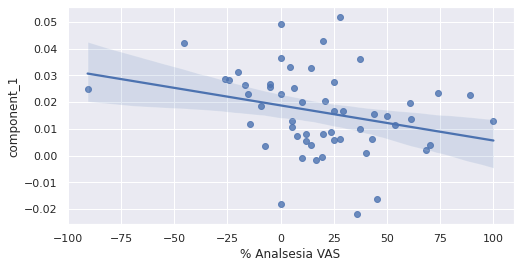

In [540]:
var = 'component_1'

df_excl = df[df.missing<6].dropna()

sns.regplot(data=df_excl, x='% Analsesia VAS', y=var)

p_value = permutation_test(
    df_excl['% Analsesia VAS'], df_excl[var], method="approximate", seed=42, num_rounds=10000, func=lambda x, y: np.abs(np.corrcoef(x, y)[1][0]),
)
p_value

0.28677132286771323

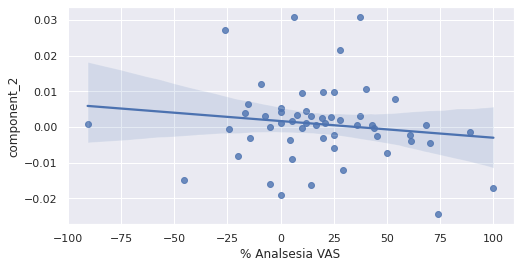

In [541]:
var = 'component_2'

df_excl = df[df.missing<6].dropna()

sns.regplot(data=df_excl, x='% Analsesia VAS', y=var)

p_value = permutation_test(
    df_excl['% Analsesia VAS'], df_excl[var], method="approximate", seed=42, num_rounds=10000, func=lambda x, y: np.abs(np.corrcoef(x, y)[1][0]),
)
p_value

0.15648435156484353

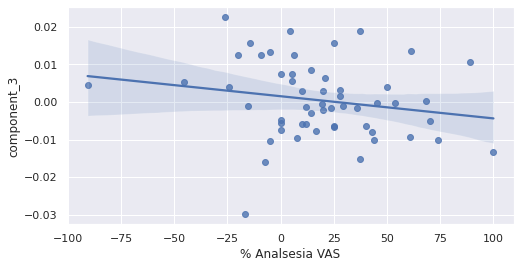

In [542]:
var = 'component_3'

df_excl = df[df.missing<6].dropna()

sns.regplot(data=df_excl, x='% Analsesia VAS', y=var)

p_value = permutation_test(
    df_excl['% Analsesia VAS'], df_excl[var], method="approximate", seed=42, num_rounds=10000, func=lambda x, y: np.abs(np.corrcoef(x, y)[1][0]),
)
p_value